
=== 处理 H2S v=1 数据集 ===
数据形状: (20000, 21)
训练温度列数: 17
测试温度列数: 3
标准化完成
训练集形状: (20000, 18)
测试集形状: (20000, 4)

=== H2S v=1 建模和评估 ===
训练样本数: 340000
测试样本数: 60000
开始训练模型...

H2S v=1 评估结果:
Test Mean Squared Error (MSE): 1.0357e+00
Test Root Mean Squared Error (RMSE): 1.0177e+00
Test Mean Absolute Error (MAE): 8.0471e-01
Test R-squared (R2): 0.5728
Test Mean Absolute Percentage Error (MAPE): 161.22%
Test Geometric Mean Error (GME): 5.3237e-01

=== 处理 H2S v=10 数据集 ===
数据形状: (2001, 21)
训练温度列数: 17
测试温度列数: 3
标准化完成
训练集形状: (2001, 18)
测试集形状: (2001, 4)

=== H2S v=10 建模和评估 ===
训练样本数: 34017
测试样本数: 6003
开始训练模型...

H2S v=10 评估结果:
Test Mean Squared Error (MSE): 9.3392e-01
Test Root Mean Squared Error (RMSE): 9.6639e-01
Test Mean Absolute Error (MAE): 7.5017e-01
Test R-squared (R2): 0.6378
Test Mean Absolute Percentage Error (MAPE): 161.74%
Test Geometric Mean Error (GME): 4.7810e-01

=== 处理 H2S v=20 数据集 ===
数据形状: (1001, 21)
训练温度列数: 17
测试温度列数: 3
标准化完成
训练集形状: (1001, 18)
测试集形状: (1001, 4)

=== H2S v=20 建模和评估 ==

/var/folders/sf/9z3vwghd1bs4_lbyb9vdjh3h0000gn/T/ipykernel_4948/2368662124.py:248: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sf/9z3vwghd1bs4_lbyb9vdjh3h0000gn/T/ipykernel_4948/2368662124.py:248: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sf/9z3vwghd1bs4_lbyb9vdjh3h0000gn/T/ipykernel_4948/2368662124.py:249: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.savefig('h2s_three_datasets_comparison.png', dpi=300, bbox_inches='tight')
/var/folders/sf/9z3vwghd1bs4_lbyb9vdjh3h0000gn/T/ipykernel_4948/2368662124.py:249: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.savefig('h2s_three_datasets_comparison.png', dpi=300, bbox_inches='tight')
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2

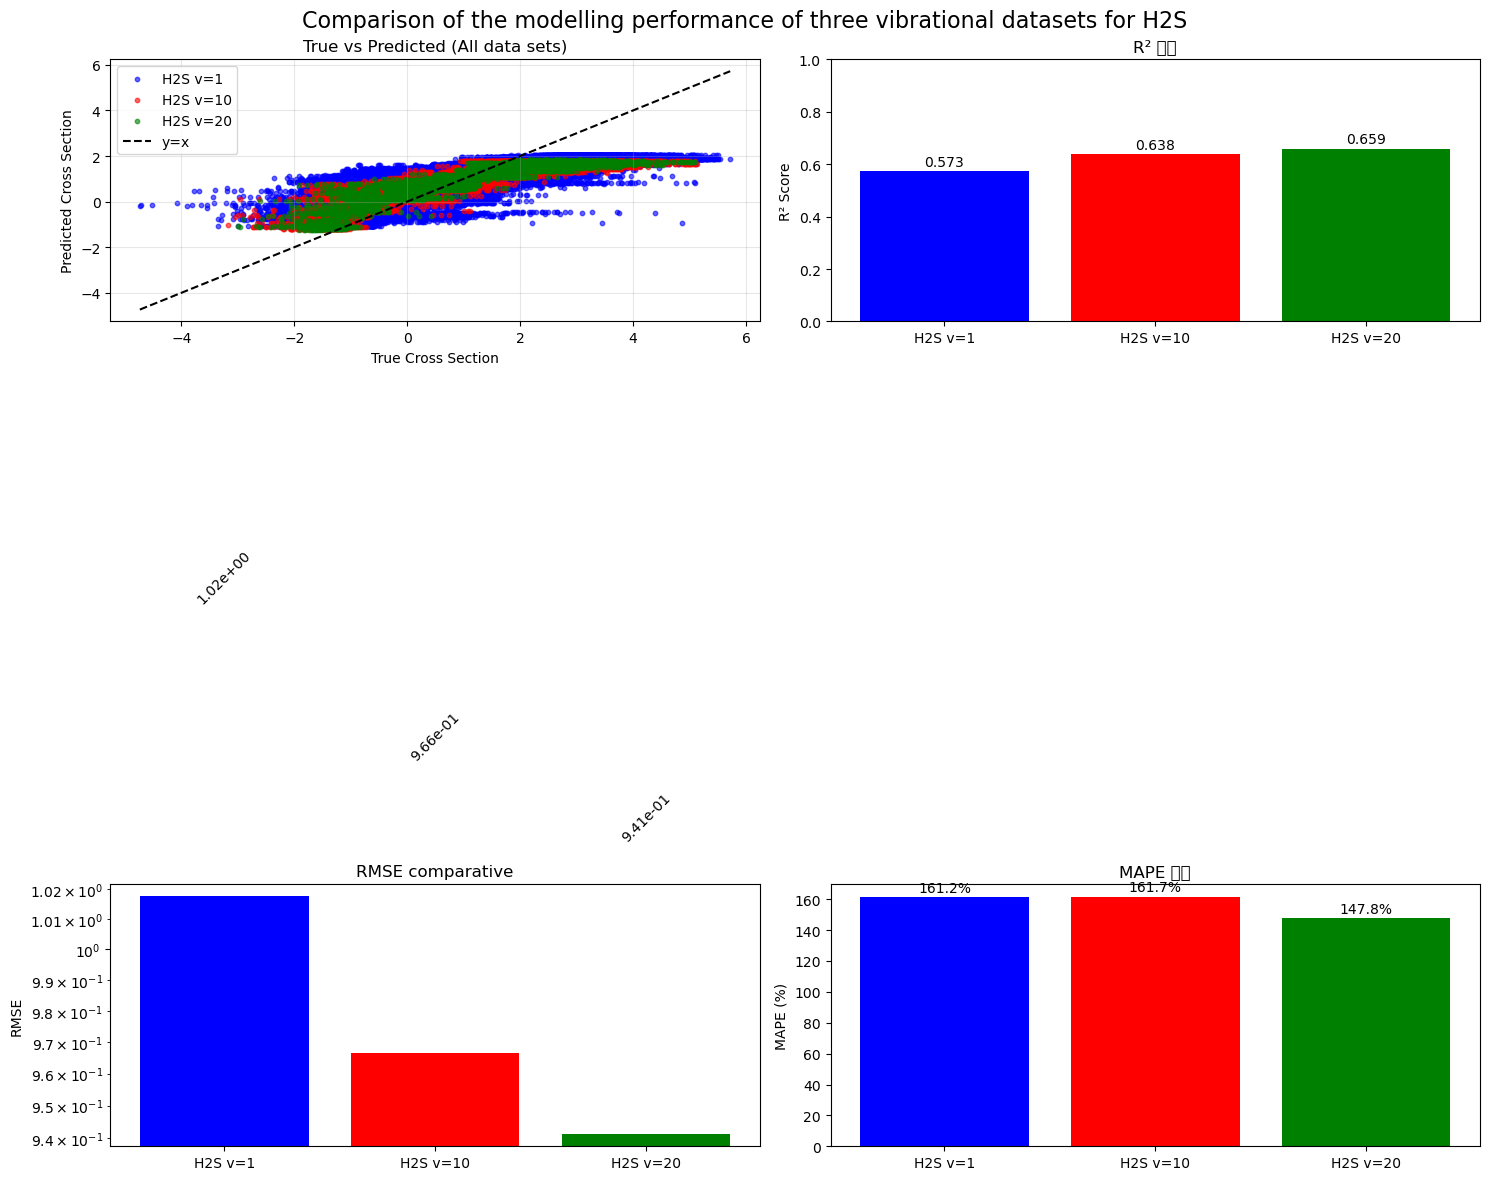

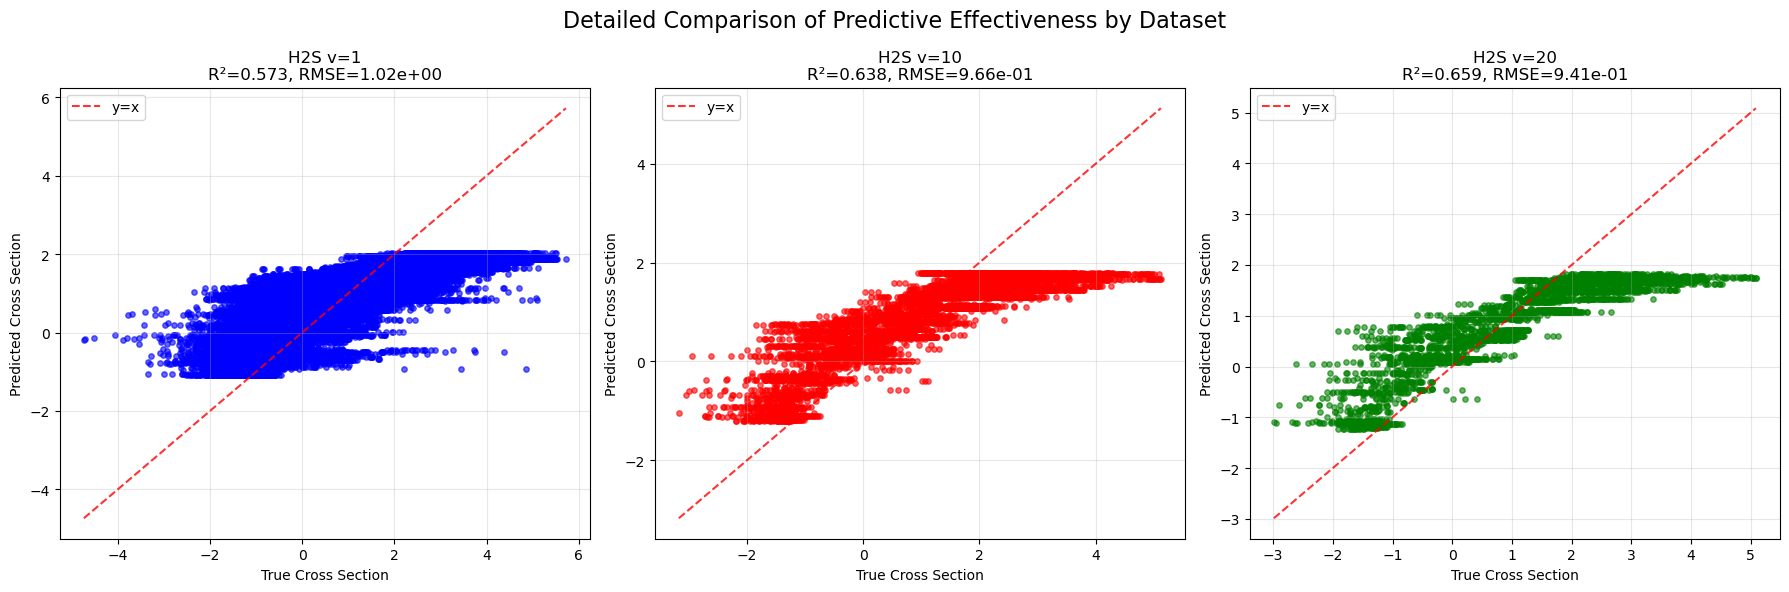


Analysis completed！
Documents generated:
1. h2s_three_datasets_comparison.png - Comprehensive Performance Comparison Chart
2. h2s_individual_predictions.png - Detailed projection maps for each dataset
3. h2s_comparison_results.xlsx - Detailed comparison results

 best R²: H2S v=20 (R² = 0.6589)
Minimum RMSE: H2S v=20 (RMSE = 9.4106e-01)


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gmean
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# 定义处理单个数据集的函数
def process_dataset(file_path, dataset_name):
    print(f"\n=== 处理 {dataset_name} 数据集 ===")
    
    # 读取数据
    df = pd.read_excel(file_path)
    print(f"数据形状: {df.shape}")
    
    # 定义要排除的列（测试集）
    columns_to_exclude = ['t=1800k', 't=1900k', 't=2000k']
    columns_to_normalize = [col for col in df.columns if col.startswith('t=') and col not in columns_to_exclude]
    
    print(f"训练温度列数: {len(columns_to_normalize)}")
    print(f"测试温度列数: {len(columns_to_exclude)}")
    
    # Step 1: 提取需要标准化的部分
    data_to_normalize = df[columns_to_normalize].copy()
    
    # Step 2: 按行计算均值和标准差
    row_means = data_to_normalize.mean(axis=1)
    row_stds = data_to_normalize.std(axis=1)
    
    # Step 3: 按行标准化（广播操作）
    df_scaled = (data_to_normalize.subtract(row_means, axis=0)).divide(row_stds, axis=0)
    
    # Step 4: 保存每行均值和标准差
    df_stats = pd.DataFrame({
        'wavenumber': df['wavenumber'],
        'row_mean': row_means,
        'row_std': row_stds
    })
    
    # Step 5: 处理测试集
    test_df = df[columns_to_exclude].copy()
    test_df = (test_df.subtract(row_means, axis=0)).divide(row_stds, axis=0)
    test_df = pd.concat([df[['wavenumber']], test_df], axis=1)
    
    # 训练集
    train_df = pd.concat([df[['wavenumber']], df_scaled], axis=1)
    
    print("标准化完成")
    print(f"训练集形状: {train_df.shape}")
    print(f"测试集形状: {test_df.shape}")
    
    return train_df, test_df, df_stats

# 定义建模和评估函数
def train_and_evaluate(train_df, test_df, dataset_name):
    print(f"\n=== {dataset_name} 建模和评估 ===")
    
    # 将宽格式转换成长格式 - 训练集
    long_df = pd.melt(
        train_df,
        id_vars='wavenumber',
        value_vars=[col for col in train_df.columns if col.startswith('t=')],
        var_name='temperature',
        value_name='cross_section'
    )
    
    # 清理 temperature 列，转成整数
    long_df['temperature'] = long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).str.replace('K', '', regex=False)
    long_df['temperature'] = long_df['temperature'].astype(int)
    
    # 准备训练特征和标签
    X_train = long_df[['wavenumber', 'temperature']]
    y_train = long_df['cross_section']
    
    # 处理测试集
    test_long_df = pd.melt(
        test_df,
        id_vars='wavenumber',
        value_vars=['t=1800k', 't=1900k', 't=2000k'],
        var_name='temperature',
        value_name='cross_section'
    )
    
    test_long_df['temperature'] = test_long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)
    
    X_test = test_long_df[['wavenumber', 'temperature']]
    y_test = test_long_df['cross_section']
    
    print(f"训练样本数: {len(X_train)}")
    print(f"测试样本数: {len(X_test)}")
    
    # 建立模型
    degree = 6
    alpha = 1.0
    model= GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=6)
    
    # 训练
    print("开始训练模型...")
    model.fit(X_train, y_train)
    
    # 预测测试集
    y_pred = model.predict(X_test)
    
    # 计算各种评估指标
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 计算MAPE，避免除0，加入一个小常数1e-8
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100  # 百分比形式
    
    # 计算预测误差的几何平均数，加入小常数避免log(0)
    geometric_mean_error = gmean(np.abs(y_test - y_pred) + 1e-8)
    
    # 打印评估指标
    print(f"\n{dataset_name} 评估结果:")
    print(f"Test Mean Squared Error (MSE): {mse:.4e}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4e}")
    print(f"Test Mean Absolute Error (MAE): {mae:.4e}")
    print(f"Test R-squared (R2): {r2:.4f}")
    print(f"Test Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Test Geometric Mean Error (GME): {geometric_mean_error:.4e}")
    
    return {
        'dataset': dataset_name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'gme': geometric_mean_error,
        'y_test': y_test,
        'y_pred': y_pred
    }

# 主程序
if __name__ == "__main__":
    # 定义数据文件路径
    datasets = {
        'H2S v=1': 'h2s_v=1.xlsm',
        'H2S v=10': 'h2s_v=10.xlsm',
        'H2S v=20': 'h2s_v=20.xlsm'
    }
    
    results = {}
    processed_data = {}
    
    # 处理每个数据集
    for name, file_path in datasets.items():
        try:
            # 数据预处理
            train_df, test_df, stats_df = process_dataset(file_path, name)
            processed_data[name] = {
                'train': train_df,
                'test': test_df,
                'stats': stats_df
            }
            
            # 建模和评估
            result = train_and_evaluate(train_df, test_df, name)
            results[name] = result
            
        except Exception as e:
            print(f"处理 {name} 时出错: {str(e)}")
            continue
    
    # 创建对比表格
    print("\n" + "="*80)
    print("三个数据集性能对比")
    print("="*80)
    
    comparison_df = pd.DataFrame([
        {
            '数据集': result['dataset'],
            'MSE': f"{result['mse']:.4e}",
            'RMSE': f"{result['rmse']:.4e}",
            'MAE': f"{result['mae']:.4e}",
            'R²': f"{result['r2']:.4f}",
            'MAPE(%)': f"{result['mape']:.2f}",
            'GME': f"{result['gme']:.4e}"
        }
        for result in results.values()
    ])
    
    print(comparison_df.to_string(index=False))
    
    # 创建可视化对比
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparison of the modelling performance of three vibrational datasets for H2S', fontsize=16)
    
    # 1. 散点图对比
    ax1 = axes[0, 0]
    colors = ['blue', 'red', 'green']
    for i, (name, result) in enumerate(results.items()):
        ax1.scatter(result['y_test'], result['y_pred'], 
                   alpha=0.6, s=10, color=colors[i], label=name)
    
    # 添加y=x线
    all_y_test = np.concatenate([result['y_test'] for result in results.values()])
    ax1.plot([all_y_test.min(), all_y_test.max()], 
             [all_y_test.min(), all_y_test.max()], 'k--', label='y=x')
    ax1.set_xlabel('True Cross Section')
    ax1.set_ylabel('Predicted Cross Section')
    ax1.set_title('True vs Predicted (All data sets)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. R²对比
    ax2 = axes[0, 1]
    r2_values = [result['r2'] for result in results.values()]
    dataset_names = [result['dataset'] for result in results.values()]
    bars = ax2.bar(dataset_names, r2_values, color=colors)
    ax2.set_ylabel('R² Score')
    ax2.set_title('R² 对比')
    ax2.set_ylim(0, 1)
    # 添加数值标签
    for bar, value in zip(bars, r2_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # 3. RMSE对比
    ax3 = axes[1, 0]
    rmse_values = [result['rmse'] for result in results.values()]
    bars = ax3.bar(dataset_names, rmse_values, color=colors)
    ax3.set_ylabel('RMSE')
    ax3.set_title('RMSE comparative')
    ax3.set_yscale('log')  # 使用对数刻度
    # 添加数值标签
    for bar, value in zip(bars, rmse_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
                f'{value:.2e}', ha='center', va='bottom', rotation=45)
    
    # 4. MAPE对比
    ax4 = axes[1, 1]
    mape_values = [result['mape'] for result in results.values()]
    bars = ax4.bar(dataset_names, mape_values, color=colors)
    ax4.set_ylabel('MAPE (%)')
    ax4.set_title('MAPE 对比')
    # 添加数值标签
    for bar, value in zip(bars, mape_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mape_values)*0.01,
                f'{value:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('h2s_three_datasets_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 单独为每个数据集创建散点图
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Detailed Comparison of Predictive Effectiveness by Dataset', fontsize=16)
    
    for i, (name, result) in enumerate(results.items()):
        ax = axes[i]
        ax.scatter(result['y_test'], result['y_pred'], alpha=0.6, s=15, color=colors[i])
        
        # 添加y=x线
        y_min, y_max = result['y_test'].min(), result['y_test'].max()
        ax.plot([y_min, y_max], [y_min, y_max], 'r--', alpha=0.8, label='y=x')
        
        ax.set_xlabel('True Cross Section')
        ax.set_ylabel('Predicted Cross Section')
        ax.set_title(f'{name}\nR²={result["r2"]:.3f}, RMSE={result["rmse"]:.2e}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('h2s_individual_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 保存对比结果到Excel
    with pd.ExcelWriter('h2s_comparison_results.xlsx') as writer:
        comparison_df.to_excel(writer, sheet_name='性能对比', index=False)
        
        # 保存每个数据集的统计信息
        for name, data in processed_data.items():
            sheet_name = name.replace('H2S ', '').replace('=', '')
            data['stats'].to_excel(writer, sheet_name=f'{sheet_name}_stats', index=False)
    
    print("\nAnalysis completed！")
    print("Documents generated:")
    print("1. h2s_three_datasets_comparison.png - Comprehensive Performance Comparison Chart")
    print("2. h2s_individual_predictions.png - Detailed projection maps for each dataset")
    print("3. h2s_comparison_results.xlsx - Detailed comparison results")
    
    # 输出最佳模型
    best_r2 = max(results.values(), key=lambda x: x['r2'])
    best_rmse = min(results.values(), key=lambda x: x['rmse'])
    
    print(f"\n best R²: {best_r2['dataset']} (R² = {best_r2['r2']:.4f})")
    print(f"Minimum RMSE: {best_rmse['dataset']} (RMSE = {best_rmse['rmse']:.4e})")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.338e+04, tolerance: 3.200e+01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.867e+03, tolerance: 3.202e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e+03, toler

    Dataset       MSE      RMSE       MAE            R2
0   H2S v=1  2.765775  1.663062  1.536813 -5.242223e+41
1  H2S v=10  2.436590  1.560958  1.433112 -6.271331e+41
2  H2S v=20  2.429945  1.558828  1.429932 -6.279258e+41


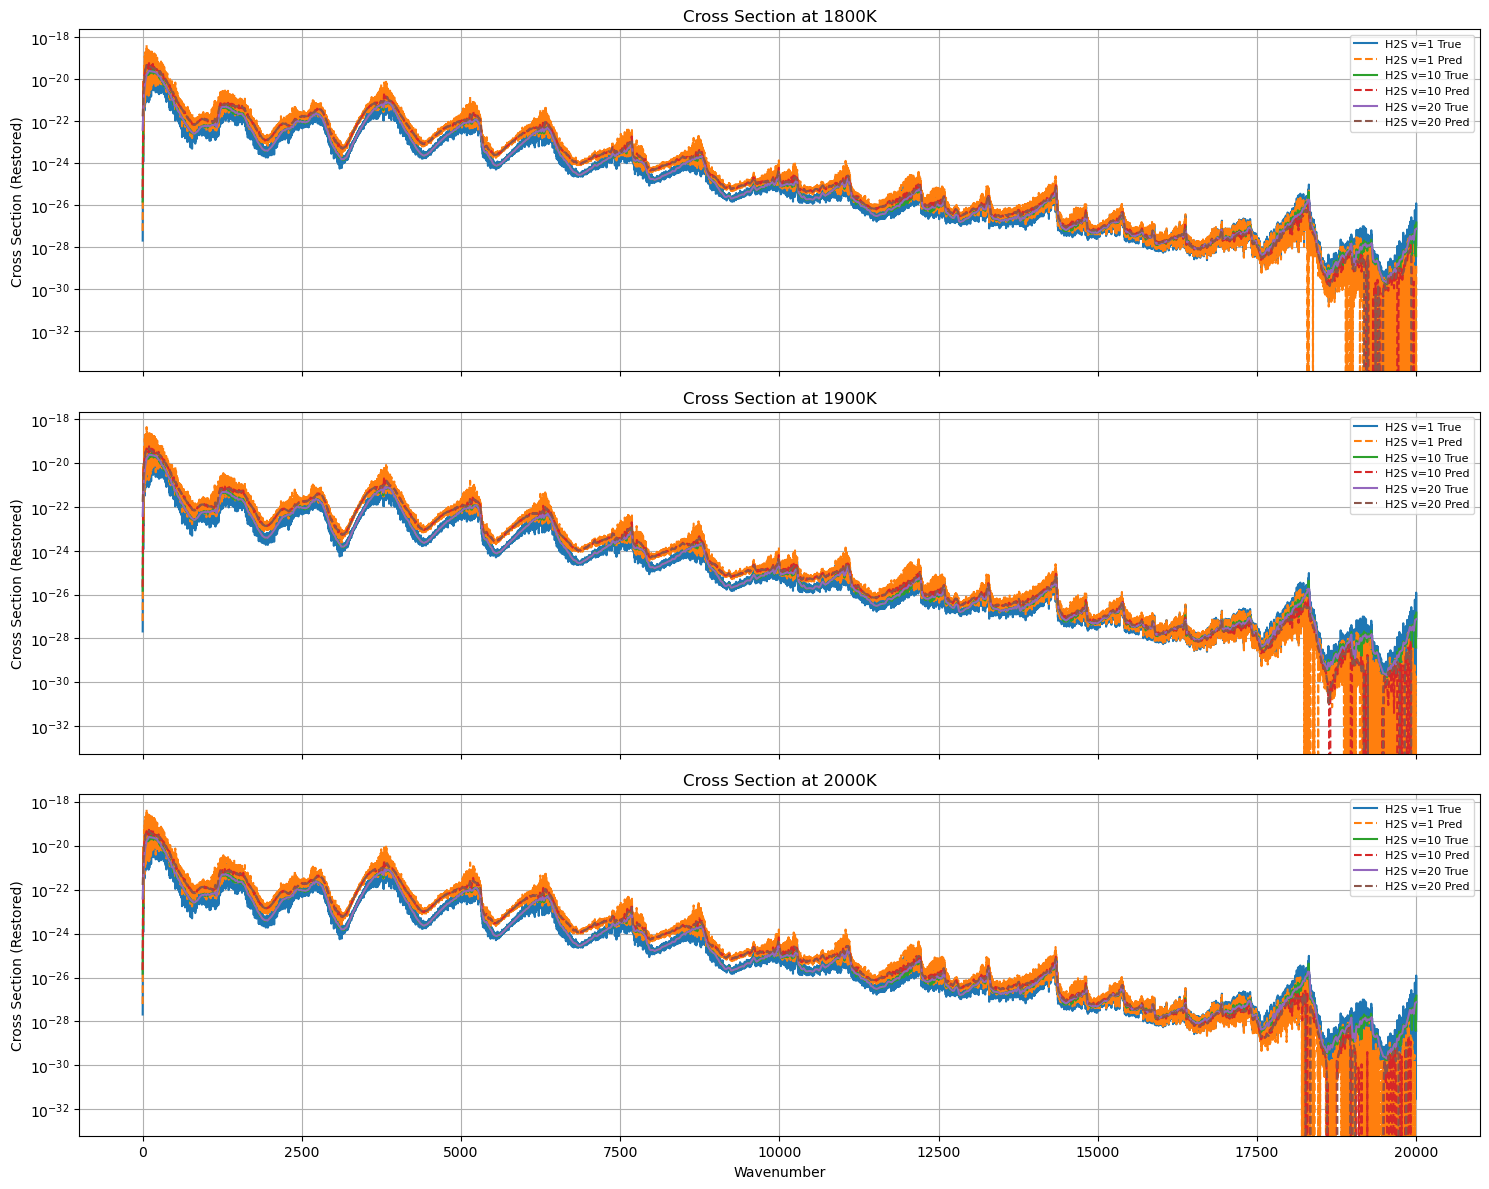

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========== 数据集路径 ==========
datasets = {
    'H2S v=1': 'h2s_v=1.xlsm',
    'H2S v=10': 'h2s_v=10.xlsm',
    'H2S v=20': 'h2s_v=20.xlsm'
}

# ========== 定义函数：标准化 + 训练 + 预测 + 反归一化 ==========
def process_dataset(name, file):
    # 读取数据
    df = pd.read_excel(file)
    df = df.rename(columns={'number': 'wavenumber'})
    
    # 划分训练/测试 (1800, 1900, 2000K 用作测试)
    columns_to_exclude = ['t=1800k', 't=1900k', 't=2000k']
    columns_to_normalize = [col for col in df.columns if col.startswith('t=') and col not in columns_to_exclude]

    # 按行标准化
    data_to_normalize = df[columns_to_normalize].copy()
    row_means = data_to_normalize.mean(axis=1)
    row_stds = data_to_normalize.std(axis=1)
    df_scaled = (data_to_normalize.subtract(row_means, axis=0)).divide(row_stds, axis=0)

    # 保存统计量
    df_stats = pd.DataFrame({
        'wavenumber': df['wavenumber'],
        'row_mean': row_means,
        'row_std': row_stds
    }).set_index('wavenumber')

    # 拼接标准化后的训练数据
    train_df = pd.concat([df[['wavenumber']], df_scaled], axis=1)

    # 转成长表
    long_df = pd.melt(
        train_df,
        id_vars='wavenumber',
        value_vars=[col for col in train_df.columns if col.startswith('t=')],
        var_name='temperature',
        value_name='cross_section'
    )
    long_df['temperature'] = long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)

    # 训练/测试集划分
    test_df = df[['wavenumber'] + columns_to_exclude].rename(columns={'number': 'wavenumber'})
    test_long_df = pd.melt(
        test_df,
        id_vars='wavenumber',
        value_vars=columns_to_exclude,
        var_name='temperature',
        value_name='cross_section'
    )
    test_long_df['temperature'] = test_long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)

    X_train, y_train = long_df[['wavenumber', 'temperature']], long_df['cross_section']
    X_test, y_test = test_long_df[['wavenumber', 'temperature']], test_long_df['cross_section']

    # 模型
    model = make_pipeline(
        PolynomialFeatures(degree=6, include_bias=False),
        Lasso(alpha=1.0, max_iter=5000)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 保存预测结果
    test_long_df['predicted'] = y_pred

    # 反归一化
    cross_section_restored = []
    predicted_restored = []
    for idx, row in test_long_df.iterrows():
        wnum = row['wavenumber']
        mean = df_stats.loc[wnum, 'row_mean']
        std = df_stats.loc[wnum, 'row_std']
        cs_restored = row['cross_section'] * std + mean
        pred_restored = row['predicted'] * std + mean
        cross_section_restored.append(cs_restored)
        predicted_restored.append(pred_restored)

    test_long_df['cross_section_restored'] = cross_section_restored
    test_long_df['predicted_restored'] = predicted_restored

    # 计算误差指标
    mse = mean_squared_error(test_long_df['cross_section'], test_long_df['predicted'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_long_df['cross_section'], test_long_df['predicted'])
    r2 = r2_score(test_long_df['cross_section'], test_long_df['predicted'])

    metrics = {'Dataset': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    return test_long_df, metrics

# ========== 循环处理所有数据集 ==========
results = {}
metrics_list = []
for name, file in datasets.items():
    df_result, metric = process_dataset(name, file)
    results[name] = df_result
    metrics_list.append(metric)

# 打印误差指标
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# ========== 画对比图 ==========
temps = [1800, 1900, 2000]
fig, axs = plt.subplots(len(temps), 1, figsize=(15, 12), sharex=True)

for i, temp in enumerate(temps):
    ax = axs[i]
    for name, df in results.items():
        subset = df[df['temperature'] == temp]
        ax.plot(subset['wavenumber'], subset['cross_section_restored'], label=f'{name} True')
        ax.plot(subset['wavenumber'], subset['predicted_restored'], linestyle='--', label=f'{name} Pred')
    ax.set_title(f'Cross Section at {temp}K')
    ax.set_ylabel('Cross Section (Restored)')
    ax.legend(fontsize=8)
    ax.grid(True)
    ax.set_yscale('log')

axs[-1].set_xlabel('Wavenumber')
plt.tight_layout()
plt.show()


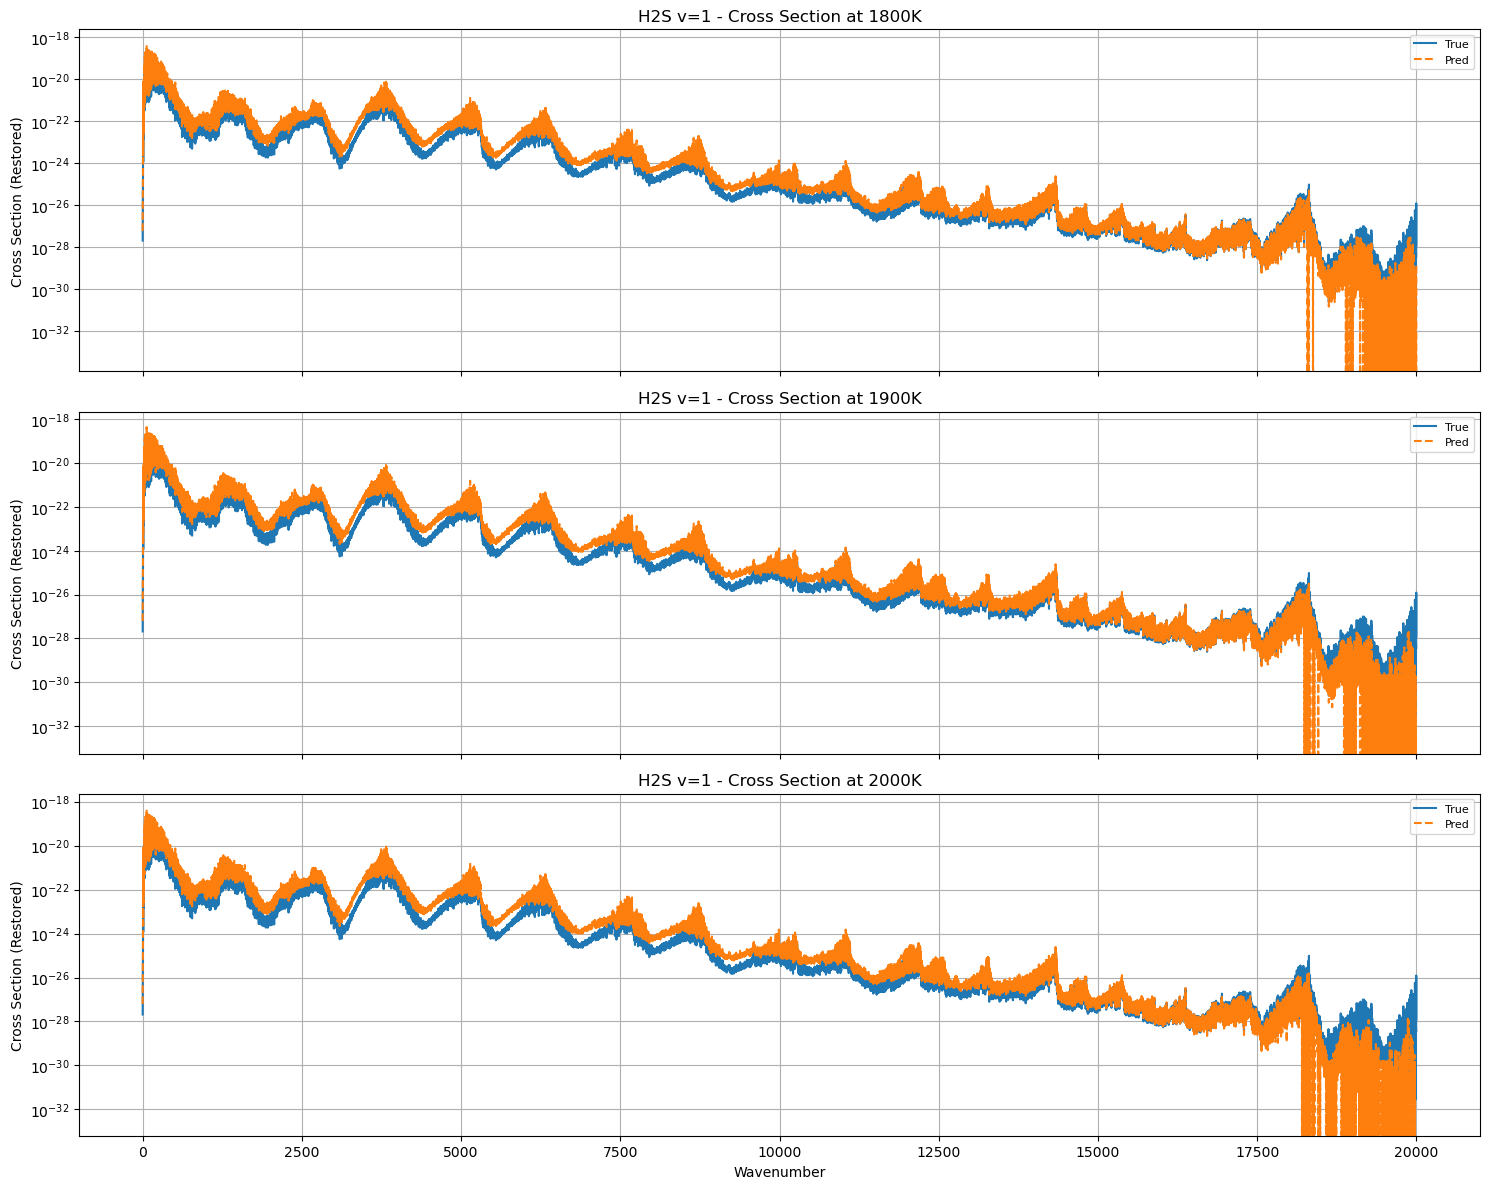

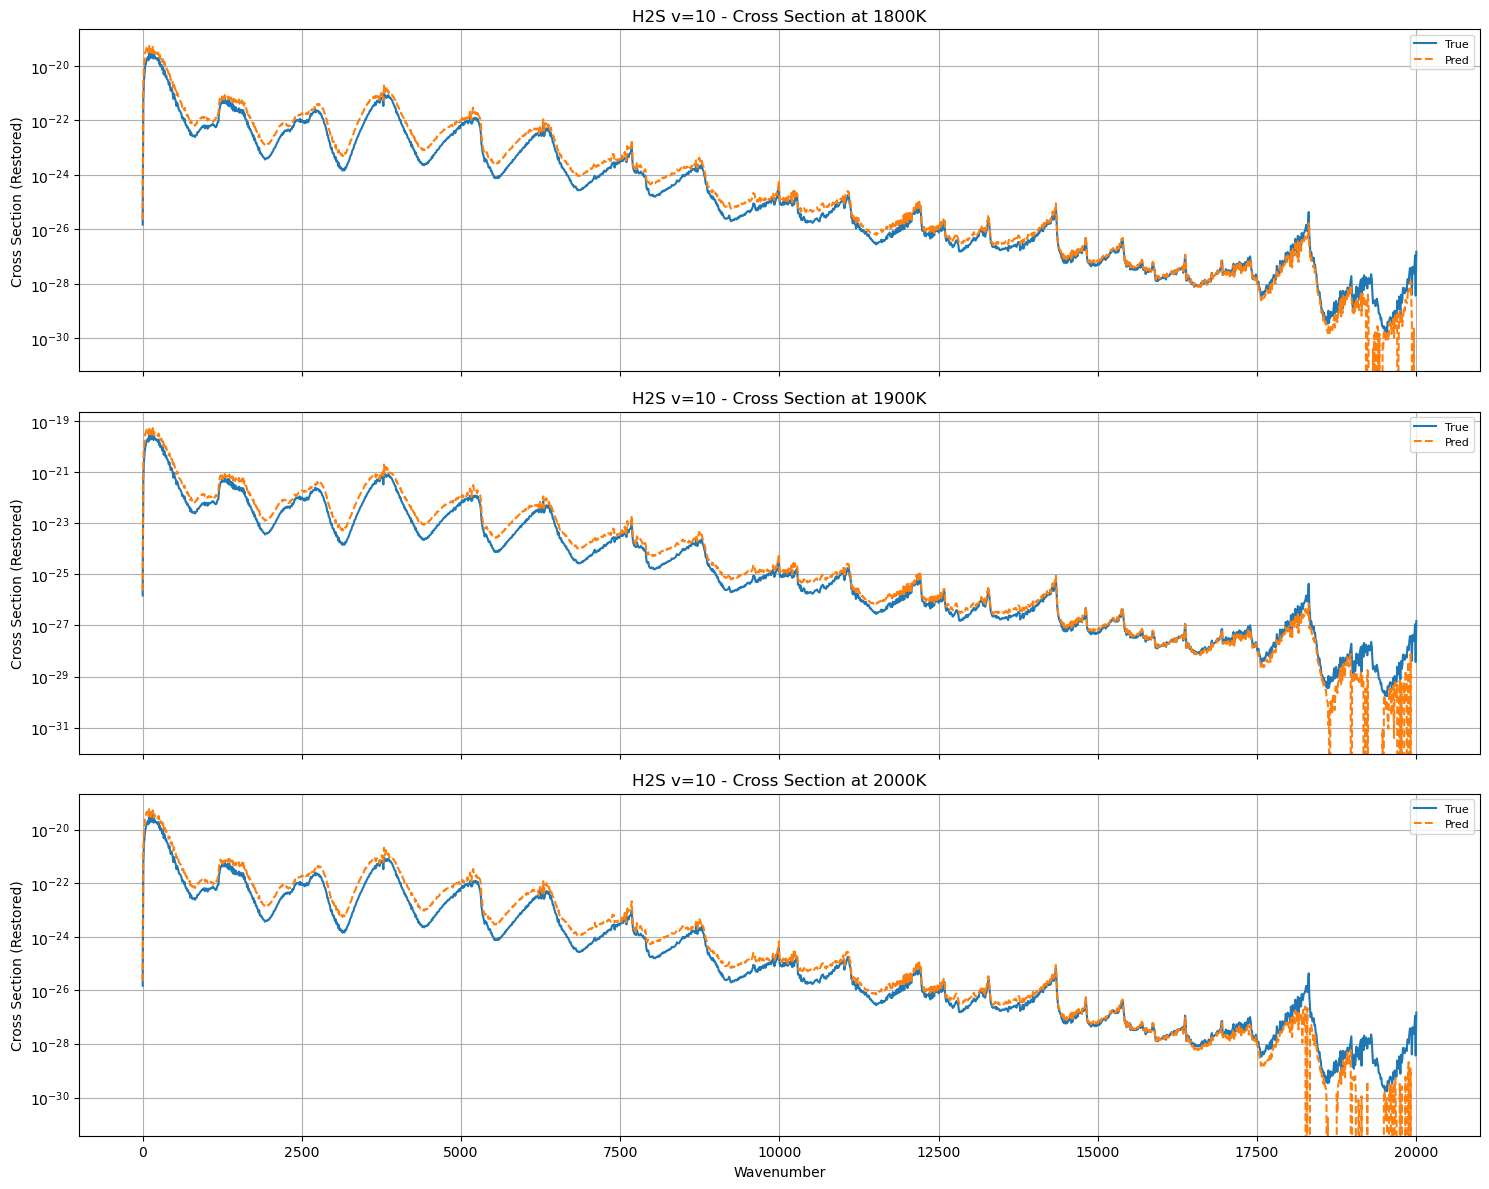

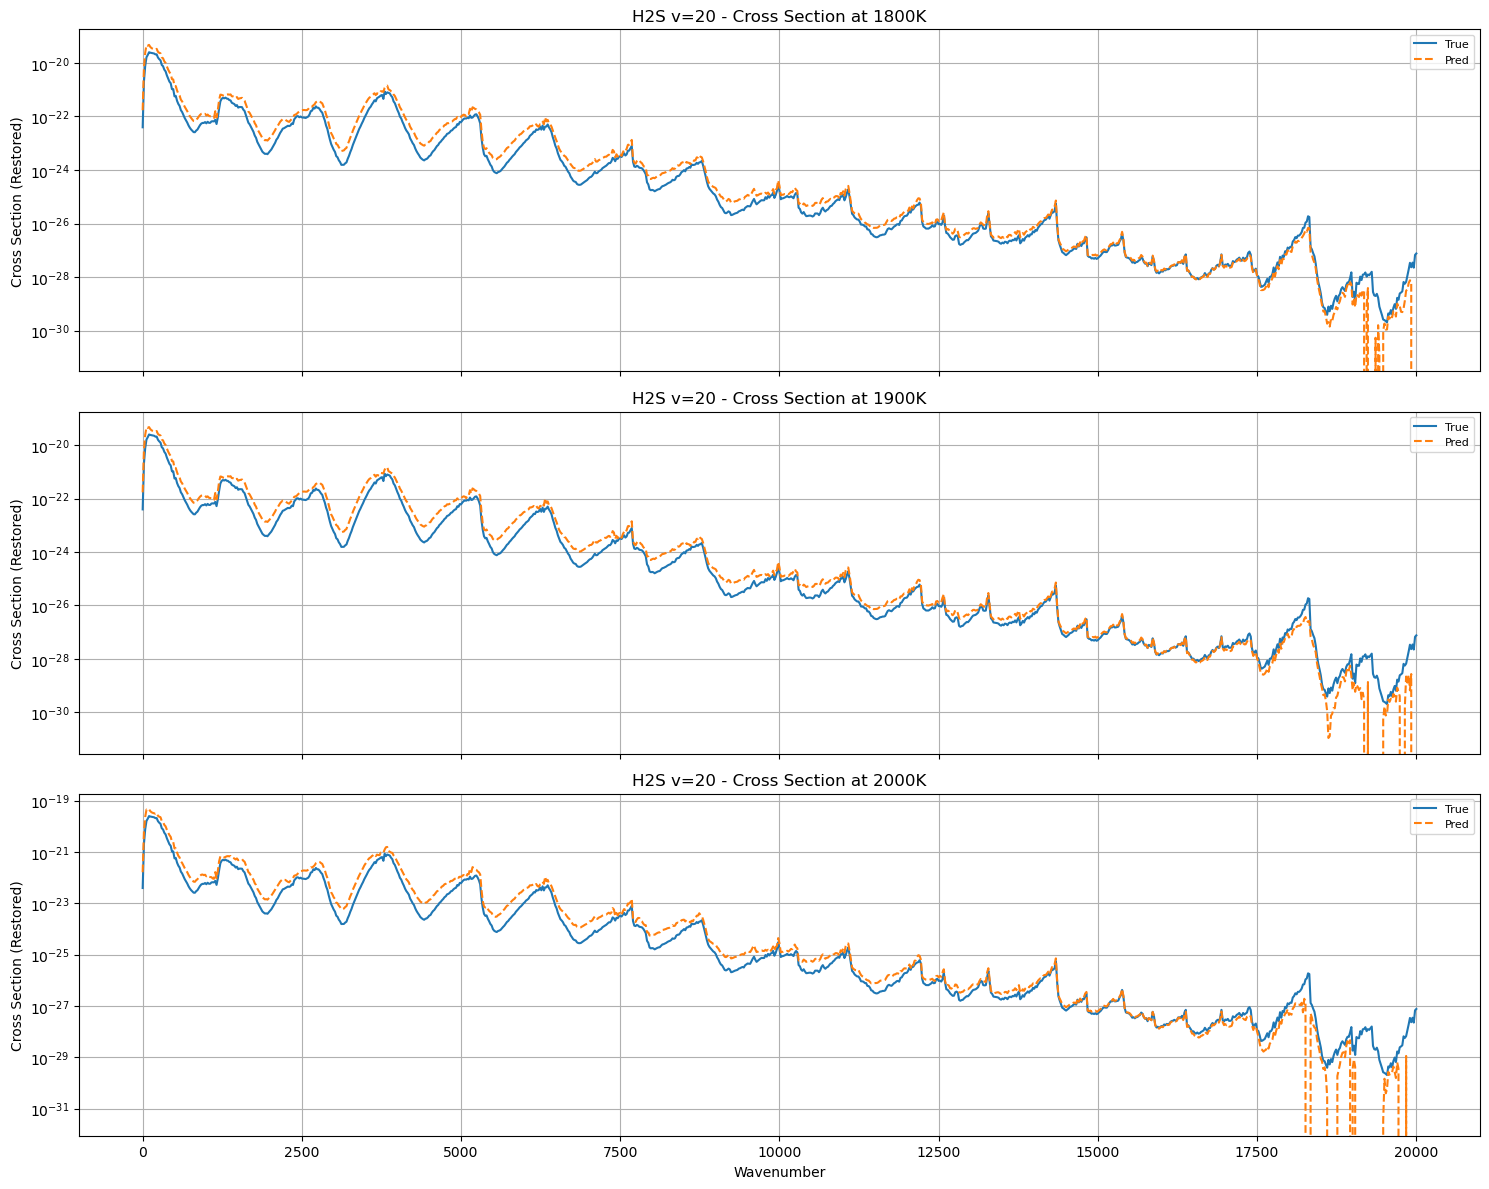

In [2]:
# ========== 每个数据集单独画一张图 ==========
temps = [1800, 1900, 2000]

for name, df in results.items():
    fig, axs = plt.subplots(len(temps), 1, figsize=(15, 12), sharex=True)

    for i, temp in enumerate(temps):
        ax = axs[i]
        subset = df[df['temperature'] == temp]
        ax.plot(subset['wavenumber'], subset['cross_section_restored'], label='True')
        ax.plot(subset['wavenumber'], subset['predicted_restored'], linestyle='--', label='Pred')
        ax.set_title(f'{name} - Cross Section at {temp}K')
        ax.set_ylabel('Cross Section (Restored)')
        ax.legend(fontsize=8)
        ax.grid(True)
        ax.set_yscale('log')

    axs[-1].set_xlabel('Wavenumber')
    plt.tight_layout()
    plt.show()
